***
# <font color=red>Building and Explaining an Anomaly Detector using AutoMLx - Experimental</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle AutoMLx Team </font></p>

***

AutoMLx Anomaly Detection Demo version 23.2.0.

Copyright © 2023, Oracle and/or its affiliates. 

Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl/

## Overview of this Notebook

In this notebook we will build an anomaly detection model using the experimental, fully unsupervised anomaly detection pipeline in Oracle AutoMLx for the public Credit Card Fraud dataset. The dataset is a binary anomaly detection dataset, and more details about the dataset can be found at https://www.openml.org/d/1597.
We explore the various options provided by the Oracle AutoMLx tool, allowing the user to control the AutoML training process. We then evaluate the different models trained by AutoML. Finally we provide an overview of the possibilites that Oracle AutoMLx provides for explaining the predictions of the tuned model.

---
## Prerequisites

  - Experience level: novice (Python and Machine Learning)
  - Professional experience: some industry experience
  
Compatible conda pack: [Oracle AutoML and Model Explanation for Python 3.8 (version 3.0)](oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/Oracle_AutoML_and_Model_Explanation_for_Python_3.8/3.0/automlx_p38_cpu_v3)

---

## Business Use

Data analytics and modeling problems using Machine Learning (ML) are becoming popular and often rely on data science expertise to build accurate ML models. Such modeling tasks primarily involve the following steps:
- Preprocess dataset (clean, impute, engineer features, normalize).
- Pick an appropriate model for the given dataset and prediction task at hand.
<!-- - Reduce the dataset size using feature selection to reduce the overall runtime of the machine learning tasks and improve model scores -->
- Tune the chosen model’s hyperparameters for the given dataset.

All of these steps are significantly time consuming and heavily rely on data scientist expertise. Unfortunately, to make this problem harder, the best feature subset, model, and hyperparameter choice widely varies with the dataset and the prediction task. Hence, there is no one-size-fits-all solution to achieve reasonably good model performance. Using a simple Python API, AutoML can quickly (faster) jump-start the datascience process with an accurately-tuned model and appropriate features for a given prediction task.

## Table of Contents

- <a href='#setup'>0. Setup</a>
- <a href='#load-data'>1. Load the Credit Card dataset</a>
- <a href='#AutoML'>2. AutoML</a>
  - <a href='#Engine'>2.0. Set the engine and deprecation warnings</a>
  - <a href='#provider'>2.1. Create an Instance of AutoML</a> 
  - <a href='#default'>2.2. Train a Model using AutoML</a> 
  - <a href='#analyze'>2.3. Analyze the AutoML optimization process </a>
      - <a href='#algorithm-selection'>2.3.1. Algorithm Selection</a>
      - <a href='#hyperparameter-tuning'>2.3.2. Hyperparameter Tuning</a>
  - <a href='#timebudget'>2.4. Specify a Time Budget to AutoML</a>
- <a href='#MLX'>3. Machine Learning Explainability (MLX)</a>
  - <a href='#MLX-initialization'> 3.1. Initialize an MLExplainer</a>
  - <a href='#MLX-global'> 3.2. Model Explanations (Global Feature Importance)</a>
  - <a href='#MLX-dependency'> 3.3. Feature Dependence Explanations</a>
  - <a href='#MLX-local'> 3.4 Prediction Explanations (Local Feature Importance)</a>
  - <a href='#MLX-whatif'> 3.5 Interactive What-If Explanations</a>
  - <a href='#Counterfactuals'> 3.6 Counterfactual Explanations</a>
  - <a href='#MLX-alfi'> 3.7 Aggregate Local Feature Importance & Local Feature Importance Built-in Sampling
  - <a href='#MLX-advanced'> 3.8 Advanced Feature Importance Options</a>
       - <a href='#MLX-changing'> 3.8.1. Change the number of iterations</a>
       - <a href='#MLX-including'> 3.8.2. Include the effects of feature interactions (with Shapley feature importance)</a>
  - <a href='#MLX-advanced-ale'>3.9. Advanced Feature Dependence Options (ALE)</a>         
- <a href='#ref'>References</a>

<a id='setup'></a>
## Setup

Basic setup for the Notebook.

In [1]:
! pip install -q rdata==0.9

%matplotlib inline
%load_ext autoreload
%autoreload 2

Load the required modules.

In [2]:
import gzip
import urllib
import rdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from pyod.models.iforest import IForest

# Settings for plots
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 15
sns.set(color_codes=True)
sns.set(font_scale=1.5)
sns.set_palette("bright")
sns.set_style("whitegrid")

import automl
from automl import init

<a id='load-data'></a>
## Load the Credit Card Fraud Dataset
We start by retrieving and reading in the dataset from provided URL.

In [3]:
url = "http://www.ulb.ac.be/di/map/adalpozz/data/creditcard.Rdata"
dst_path = "./creditcard.Rdata"

with open(dst_path, 'wb') as fout:
    fout.write(urllib.request.urlopen(url).read())
parsed_res = rdata.parser.parse_file(dst_path)
res = rdata.conversion.convert(parsed_res)
dataset = res['creditcard'].reset_index(drop=True).drop(['Time'], axis=1)

In this case, the target is identified by the `Class` column.

In [4]:
y = dataset.loc[:, 'Class']

We reduce the total number of features to 20 to have a reasonable training time for this demonstration.

In [5]:
df = dataset.iloc[:, :20]

Our pipeline currently only allows the indices types to be strings. Make sure to convert the indices types before any use of the pipeline

In [6]:
df.columns = df.columns.astype(str)

Since the dataset is not split into training and validation sets by default, we now split it into training (60%) and test (40%) datasets. The training set will be used to create a Machine Learning model using AutoML, and the test set will be used to evaluate the model's performance on unseen data.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df, y, train_size=0.6, random_state=0, stratify=y)
                                                 
X_train.shape, X_test.shape

((170884, 20), (113923, 20))

Again to keep the training time reasonable, we also downsample to use 5% of the total training set. 

In [8]:
X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=0.05, random_state=0, stratify=y_train)

X_train.shape

(8544, 20)

We also need to reset the indexes after our downsampling.

In [9]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

Lets look at a few of the samples in the training dataset.

In [10]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
0,-0.716073,0.225322,3.761183,3.207240,-0.495804,1.865745,-0.678000,0.458706,-0.009656,0.484059,0.026032,1.070390,0.905135,-1.490118,-1.857273,-0.478333,0.224669,0.763987,1.715066,0.421615
1,-0.287669,1.355348,0.607857,0.564008,0.823146,-0.623391,0.846476,-0.026066,-0.968745,-0.953380,1.469807,0.470426,0.426923,-1.388217,0.138532,0.771883,0.503981,1.289862,-0.073898,0.021523
2,-1.360701,0.068936,1.547622,0.968746,-2.539901,1.505830,2.200844,-0.087798,1.034511,-0.918203,-0.866630,0.289333,-1.194264,-0.939673,-2.124787,-0.923653,0.630370,-1.355050,-0.591845,-0.520554
3,-1.167623,-0.206586,1.155390,-1.460830,-1.248562,-0.637028,0.015802,0.154537,-3.190664,0.822285,0.061631,-0.513346,1.103738,0.029712,0.751646,-1.206843,1.420112,-0.898657,0.463735,-0.318270
4,-0.771096,-0.882119,-0.583668,-0.087184,-1.984118,0.750064,1.243510,0.479466,0.410805,-1.674414,-0.841014,-0.267114,0.487951,-1.263536,1.160706,1.723230,-0.083639,1.335979,-1.330248,0.989092


The Credit card fraud dataset contains numerical data.

In [11]:
pd.DataFrame({'Data type': X_train.dtypes}).T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
Data type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


The Oracle AutoMLx solution automatically handles missing values by dropping features with too many missing values, and filling in the remaining missing values based on the feature type.

In this case, there are no such missing values in our training dataset.

In [12]:
pd.DataFrame({'% missing values': X_train.isnull().sum() * 100 / len(df)}).T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
% missing values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We visualize the distribution of the target variable in the data. The dataset is heavily unbalanced, as is often the case in the anomaly detection use-case.  

[Text(0, 0, '8529'), Text(0, 0, '15')]

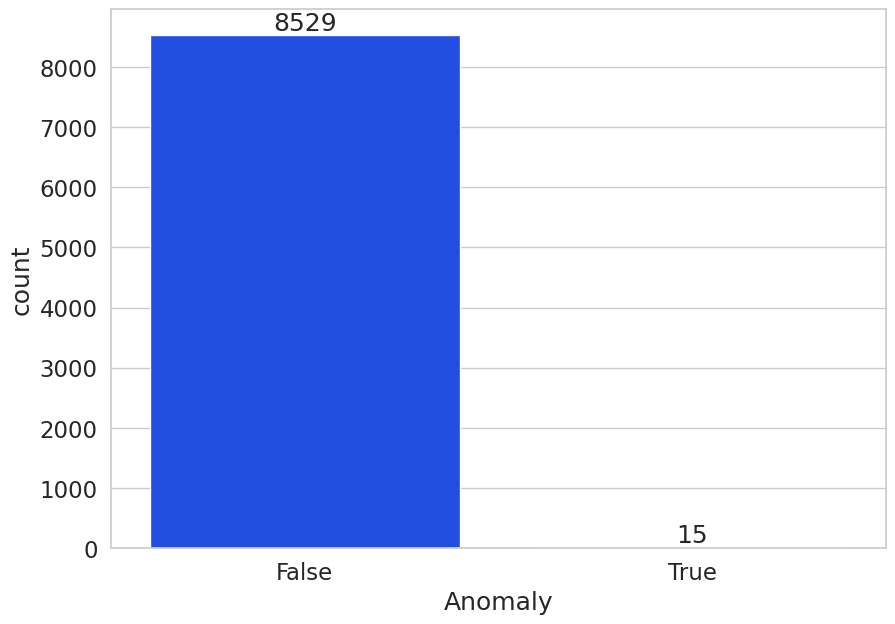

In [13]:
y_df = pd.DataFrame(y_train)
y_df.columns = ['income']

ax = sns.countplot(x='income', data=y_df)
ax.set(xlabel='Anomaly', xticklabels=['False', 'True'])
ax.bar_label(ax.containers[0])

<a id='AutoML'></a>
## AutoML

<a id='Engine'></a>
### Setting the engine and deprecation warnings
The AutoML pipeline offers the function `init`, which allows to initialize the parallelization engine. 

In [14]:
init(engine='dask')

[2023-05-29 01:40:26,653] [automl.xengine] Using Dask Execution


<automlx-23.2.0>/automl/interface/default.py:79: AutoMLxDeprecationWarning: engine dask is deprecated and will be removed in version 23.3.0.
<automlx-23.2.0>/automl/interface/default.py:82: AutoMLxDeprecationWarning: engine option dask_scheduler is deprecated and will be removed in version 23.3.0


As you can see from the above deprecation warning, dask and it's related configuration options are deprecated, and will be removed in AutoMLx version 23.3.0. This, along with a few other API changes, are coming in 23.3.0. By default, the AutoMLx package is configured to display deprecation warnings for all such changes. However, they can be disabled for any newly-created AutoMLx objects via `init`. 

We will also switch to the `'local'` parallelization engine, which uses python's multiprocessing library for parallelism instead.

In [15]:
init(engine='local', check_deprecation_warnings=False)

[2023-05-29 01:40:27,687] [automl.interface] Execution engine (local) has already been initialized. Reinitializing!
[2023-05-29 01:40:28,062] [automl.xengine] Local ProcessPool execution (n_jobs=16)


<a id='provider'></a>
### Create an instance of AutoML for Unsupervised Anomaly Detection - Experimental Feature

The Oracle AutoMLx solution provides a pipeline that automatically finds a tuned model given a prediction task and a training dataset. In particular it allows to find a tuned model for the task of Unsupervised Anomaly Detection (UAD), where the training labels (whether a training point is an anomaly or not) are unknown.

The AutoML UAD Pipeline consists of three main modules: 
- **Preprocessing** : Clean, impute, engineer, and normalize features.
- **Algorithm Selection** : Identify the right algorithm for a given dataset, choosing from amongst the following Outlier Detectors (OD):
    - IsolationForestOD
    - SubspaceOD
    - HistogramOD
    - ClusteringLocalFactorOD
    - PrincipalCompOD
    - MinCovOD
    - AutoEncoder
    - KNearestNeighborsOD
    - OneClassSVMOD
- **Hyperparameter Tuning** : Find the best model hyperparameters that maximize score for the given dataset.

All these pieces are readily combined into a simple AutoML pipeline which automates the entire Machine Learning process with minimal user input/interaction.

<a id='default'></a>
### Train a model using Oracle AutoMLx

The AutoML API is quite simple to work with. We create an instance of the pipeline. Next, the training data is passed to the `fit()` function which successively executes the three previously mentioned modules.

A model is then generated and can be used for prediction tasks. We then evaluate the performance of the model on unseen data (`X_test`) using the F1-score.

In [16]:
est = automl.Pipeline(task='anomaly_detection', score_metric='unsupervised_unify95')
est.fit(X_train, y=None) 
# In the above line, even though y_train is available for this dataset, 
# we ignore it to treat the problem as an unsupervised problem
y_pred = est.predict(X_test)

score_default = f1_score(y_test.astype(int), y_pred)

print(f'F1-Score on test data : {score_default}')

[2023-05-29 01:40:28,946] [automl.pipeline] Random state (7) is used for model builds
[2023-05-29 01:40:29,601] [automl.pipeline] Dataset shape: (8544, 20)
[2023-05-29 01:40:29,613] [automl.pipeline] Running Auto-Preprocessing
[2023-05-29 01:40:29,663] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (8544, 20), cv: None
[2023-05-29 01:40:29,705] [automl.models] === ERROR: Module (automl.models.anomaly_detection.sklearn.ae_wrapper) is not available/installed ===
[2023-05-29 01:40:29,706] [automl.models] Model (AutoEncoder) not found
[2023-05-29 01:40:29,707] [automl.pipeline] Running Model Selection
[2023-05-29 01:40:42,081] [automl.pipeline] Model Selection completed. Selected model: ['MinCovOD']
[2023-05-29 01:40:42,082] [automl.pipeline] Adaptive Sampling Disabled
[2023-05-29 01:40:42,083] [automl.pipeline] Adaptive Sampling Completed. Updated Dataset Shape: (8544, 20), Valid Shape: (8544, 20), CV: None, Class counts: N/A
[2023-05-29 01:40:42,083] [automl.pipeline] 

<a id='analyze'></a>
### Analyze the AutoML optimization process

During AutoML training, a summary of the optimization process is logged, containing:
- Information about the training data.
- Information about the AutoML pipeline, such as:
    - Selected algorithm that was the best choice for this data;
    - Selected hyperparameters for the selected algorithm.

AutoML provides a `print_summary()` API to output all the different trials performed.

In [17]:
est.print_summary()

Training Dataset size,"(8544, 20)"
Validation Dataset size,None
CV,None
Optimization Metric,unsupervised_unify95
Selected Features,"Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20'], dtype='object')"
Selected Algorithm,MinCovOD
Time taken,19.0917
Selected Hyperparameters,"{'assume_centered': False, 'contamination': 0.0016385767790262173, 'random_state': 7, 'store_precision': True, 'support_fraction': 0.8407835912414399}"
AutoML version,23.2.0
Python version,"3.8.16 (default, Mar 2 2023, 03:21:46) \n[GCC 11.2.0]"


Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time,Memory Usage (GB)
MinCovOD_HT,8544,20,0.9949,"{'assume_centered': False, 'support_fraction': 0.8407885689521141}",2.3326,"(0.00771331787109375, None)"
MinCovOD_HT,8544,20,0.9949,"{'assume_centered': False, 'support_fraction': 0.8407835912414399}",2.3436,"(0.00983428955078125, None)"
MinCovOD_HT,8544,20,0.9915,"{'assume_centered': True, 'support_fraction': 0.8407885689521141}",2.3648,"(0.009815216064453125, None)"
MinCovOD_HT,8544,20,0.9915,"{'assume_centered': True, 'support_fraction': 0.8407835912414399}",2.4238,"(0.009807586669921875, None)"
MinCovOD_AS,8544,20,0.9882,"{'assume_centered': False, 'support_fraction': None}",3.9847,0.012
...,...,...,...,...,...,...
PrincipalCompOD_AS,8544,20,0.8803,"{'whiten': False, 'n_components': 0.9999, 'svd_solver': 'full', 'weighted': True, 'standardization': True}",0.0250,0.0
KNearestNeighborsOD_AS,8544,20,0.8563,"{'n_neighbors': 5, 'method': 'largest', 'radius': 1.0}",7.5972,0.6732
IsolationForestOD_AS,8544,20,0.8306,"{'n_estimators': 100, 'max_samples': 'auto', 'max_features': 1.0}",1.1551,0.0045
HistogramOD_AS,8544,20,0.8076,"{'n_bins': 10, 'alpha': 0.1, 'tol': 0.5}",2.2014,0.0463


We also provide the capability to visualize the results of each stage of the AutoML pipeline. 

<a id='algorithm-selection'></a>
#### Algorithm Selection

The plot below shows the scores predicted by Algorithm Selection for each algorithm. The horizontal line shows the average score across all algorithms. Algorithms below the line are colored turquoise, whereas those with a score higher than the mean are colored teal. Here we can see that the `MinCovOD` achieved the highest predicted score (orange bar), and is chosen for subsequent stages of the Pipeline.

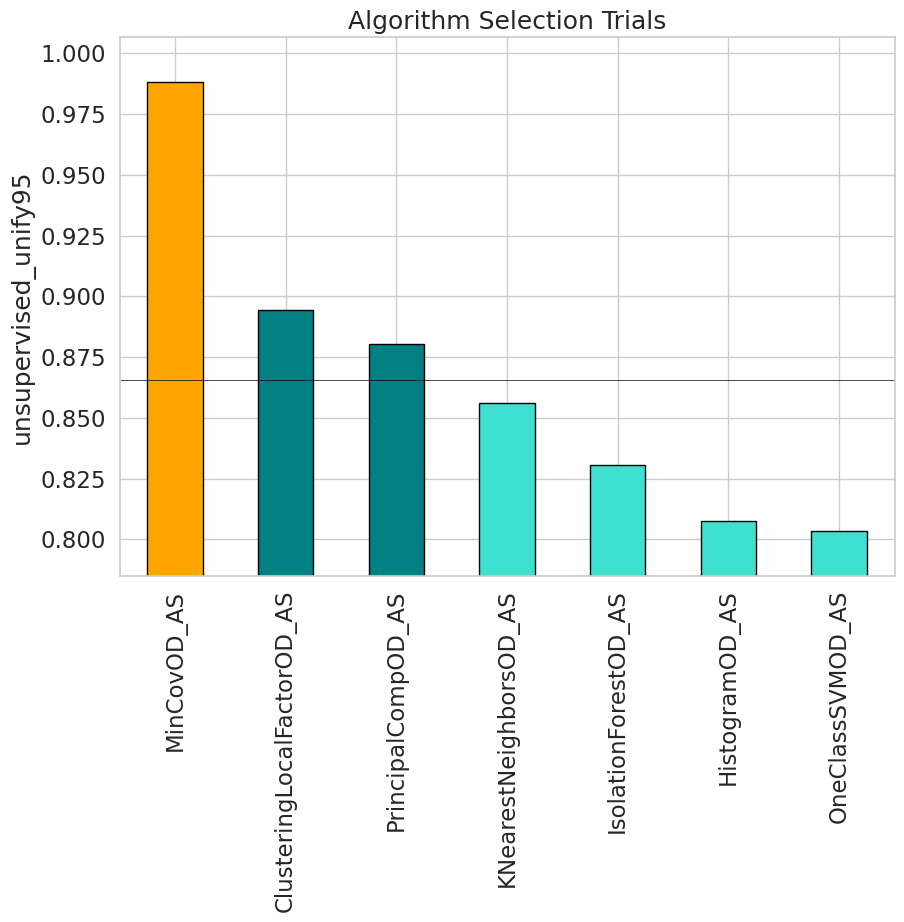

In [18]:
# Each trial is a tuple of
# (algorithm, no. samples, no. features, mean CV score, hyperparameters, 
# all CV scores, total CV time (s), memory usage (Gb))
trials = est.model_selection_trials_
colors = []
scores = [x[3] for x in trials]
models = [x[0] for x in trials]
y_margin = 0.10 * (max(scores) - min(scores))
s = pd.Series(scores, index=models).sort_values(ascending=False)

for f in s.keys():
    if f == '{}_AS'.format(est.selected_model_):
        colors.append('orange')
    elif s[f] >= s.mean():
        colors.append('teal')
    else:
        colors.append('turquoise')
        

fig, ax = plt.subplots(1)
ax.set_title("Algorithm Selection Trials")
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.set_ylabel(est.inferred_score_metric[0])
s.plot.bar(ax=ax, color=colors, edgecolor='black')
ax.axhline(y=s.mean(), color='black', linewidth=0.5)
plt.show()

<a id='hyperparameter-tuning'></a>
#### Hyperparameter Tuning

Hyperparameter Tuning is the last stage of the AutoML pipeline, and focuses on improving the chosen algorithm's score on the dataset. We use a novel algorithm to search across many hyperparameters dimensions, and converge automatically when optimal hyperparameters are identified. Each trial in the graph below represents a particular hyperparameters configuration for the selected model.

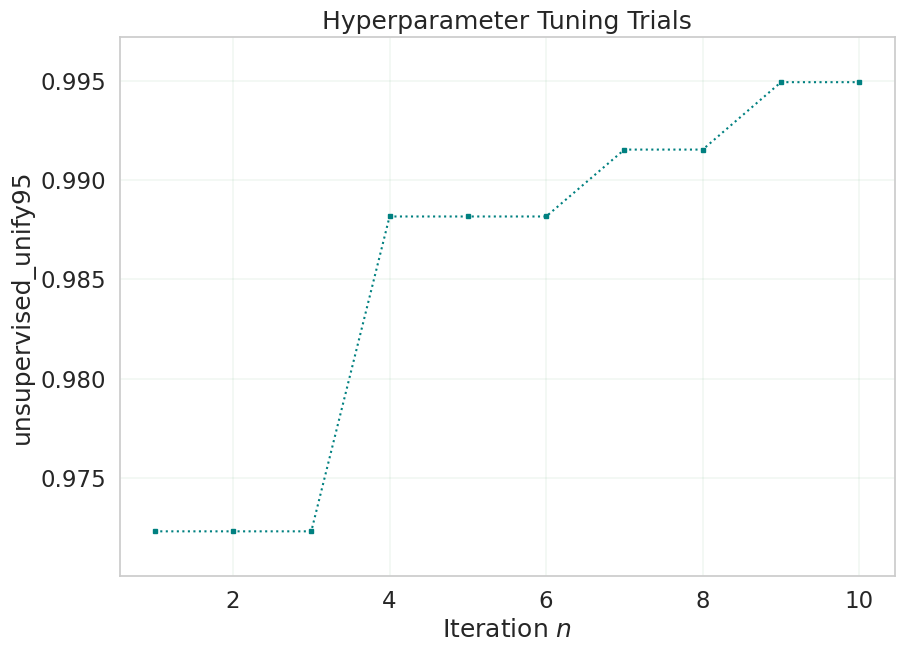

In [19]:
# Each trial is a tuple of
# (algorithm, no. samples, no. features, mean CV score, hyperparameters, 
# all CV scores, total CV time (s), memory usage (Gb))
trials = est.tuning_trials_
scores = [x[3] for x in reversed(trials)]
y_margin = 0.10 * (max(scores) - min(scores))


fig, ax = plt.subplots(1)
ax.set_title("Hyperparameter Tuning Trials")
ax.set_xlabel("Iteration $n$")
ax.set_ylabel(est.inferred_score_metric[0])
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(range(1, len(trials) + 1), scores, 'k:', marker="s", color='teal', markersize=3)
plt.show()

#### Confusion Matrix
Evaluating an anomaly detection model is slightly more involved. Essentially, we would like to know when the model was wrong and when the model was right. We use a **Confusion Matrix** to help us visualize the model's behavior.

Text(83.25, 0.5, 'Actual')

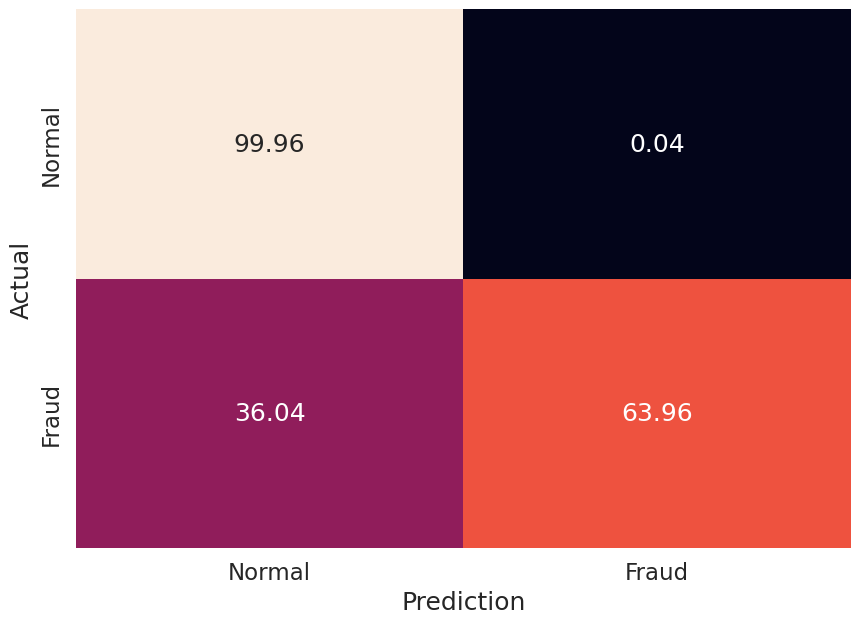

In [20]:
cm = confusion_matrix(y_test.astype(int), y_pred, labels=[False, True])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(cm)
df_cm = df_cm * 100

ax = sns.heatmap(df_cm, annot=True, fmt='.2f', cbar=False, 
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])

ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')

<a id='timebudget'></a>
### Specify a time budget to Oracle AutoMLx
The Oracle AutoMLx tool also allows a user to specify a time budget in seconds. Given the small size of this dataset, we give a small time budget of 10 seconds using the `time_budget` argument to `fit()`.

In [21]:
est_timebudget = automl.Pipeline(task='anomaly_detection', score_metric='unsupervised_unify95')
est_timebudget.fit(X_train, y=None, time_budget=10)
y_pred = est_timebudget.predict(X_test)
score_timebudget = f1_score(y_test.astype(int), y_pred)

print(f'F1-Score on test data : {score_timebudget}')

[2023-05-29 01:40:56,684] [automl.pipeline] Random state (7) is used for model builds
[2023-05-29 01:40:57,326] [automl.pipeline] Dataset shape: (8544, 20)
[2023-05-29 01:40:57,337] [automl.pipeline] Running Auto-Preprocessing
[2023-05-29 01:40:57,384] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (8544, 20), cv: None
[2023-05-29 01:40:57,413] [automl.models] === ERROR: Module (automl.models.anomaly_detection.sklearn.ae_wrapper) is not available/installed ===
[2023-05-29 01:40:57,414] [automl.models] Model (AutoEncoder) not found
[2023-05-29 01:40:57,416] [automl.pipeline] Running Model Selection
[2023-05-29 01:41:09,059] [automl.pipeline] Model Selection completed. Selected model: ['MinCovOD']
[2023-05-29 01:41:09,060] [automl.pipeline] Adaptive Sampling Disabled
[2023-05-29 01:41:09,061] [automl.pipeline] Adaptive Sampling Completed. Updated Dataset Shape: (8544, 20), Valid Shape: (8544, 20), CV: None, Class counts: N/A
[2023-05-29 01:41:09,063] [automl.pipeline] 

<a id='MLX'></a>
## Machine Learning Explainability

For a variety of decision-making tasks, getting only a prediction as model output is not sufficient. A user may wish to know why the model outputs that prediction, or which data features are relevant for that prediction. For that purpose the Oracle AutoMLx solution defines the `MLExplainer` object, which allows to compute a variety of model explanations.

<a id='MLX-initializing'></a>
### Initialize an MLExplainer

The `MLExplainer` object takes as argument the trained model, the training data and the task. If you know the labels for your dataset, you may provide them; however, since we are dealing with anomaly detection they are optional. When the labels are not provided, we will use the model's predictions instead. 

In [22]:
explainer = automl.MLExplainer(est,
                               X_train,
                               target_names=['Normal', 'Anomaly'],
                               task='anomaly_detection')

<a id='MLX-global'></a>
### Model Explanations (Global Feature Importance)

The notion of Global Feature Importance intuitively measures how much the model's performance (relative to the model's original predictions or the provided train labels, if available) would change if a given feature were dropped from the dataset, ***and the model was retrained***. (Note that this is unlike the default explainers for classification and regression tasks, which explain the model as if it were not retrained. Also unlike these supervised explainers, the anomaly detection explainer does not support interventional explanations.) Note that this notion of feature importance still considers each feature independently from all other features.

#### Compute the importance

By default we use a permutation method to successively measure the importance of each feature. Such a method therefore runs in linear time with respect to the
number of features in the dataset. 

The method `explain_model()` allows to compute such feature importances. It also provides 95% confidence intervals for each feature importance.

In [23]:
result_explain_model_default = explainer.explain_model()

#### Visualization

There are two options to show the explanation's results:
- `to_dataframe()` will return a dataframe of the results.
- `show_in_notebook()` will show the results as a bar plot.

The features are returned in decreasing order of importance.

In [24]:
result_explain_model_default.to_dataframe()

,feature,attribution,upper_bound,lower_bound
0,V13,0.000019,0.000099,-0.000061
2,V5,0.000019,0.000099,-0.000061
3,V6,0.000019,0.000099,-0.000061
1,V15,0.000019,0.000099,-0.000061
12,V19,0.000000,0.000000,0.000000
18,V8,0.000000,0.000000,0.000000
17,V7,0.000000,0.000000,0.000000
16,V4,0.000000,0.000000,0.000000
15,V3,0.000000,0.000000,0.000000
14,V20,0.000000,0.000000,0.000000


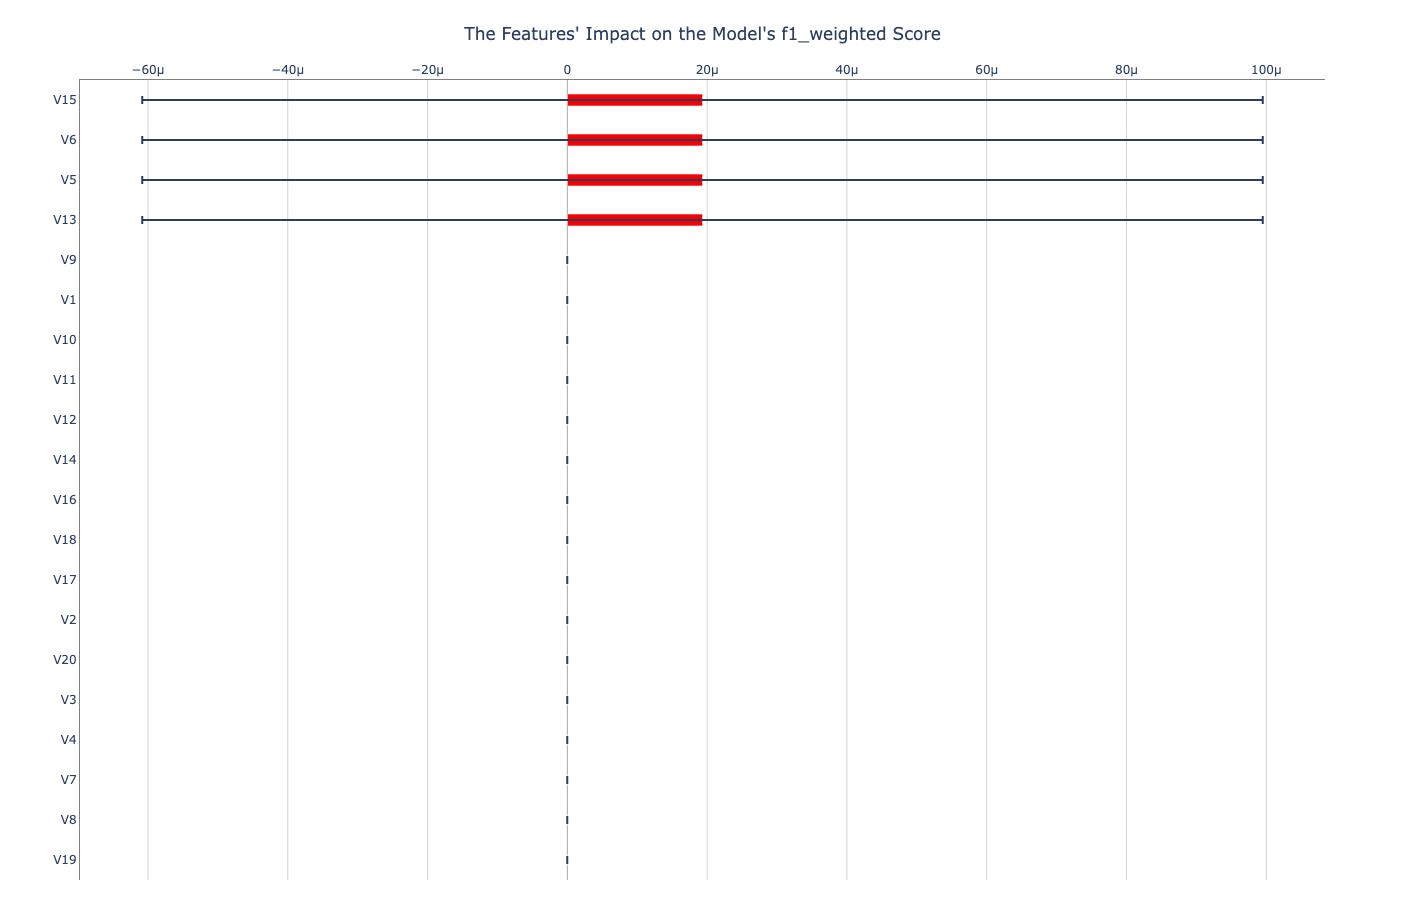

In [25]:
result_explain_model_default.show_in_notebook()

###  Feature Dependence Explanations (Partial Dependence Plots)

Another way to measure dependency on a feature is through a partial dependence plot (PDP). Given a dataset, a PDP displays the average output of the model as a function of the value of the selected set of features. 

The X-axis is the value of the feature `V17` and the y-axis is the corresponding outputted price. Since we are considering the whole dataset, while the shaded interval corresponds to a 95% confidence interval for the average.

The histogram on top shows the distribution of the value of the feature `V17` in the dataset.

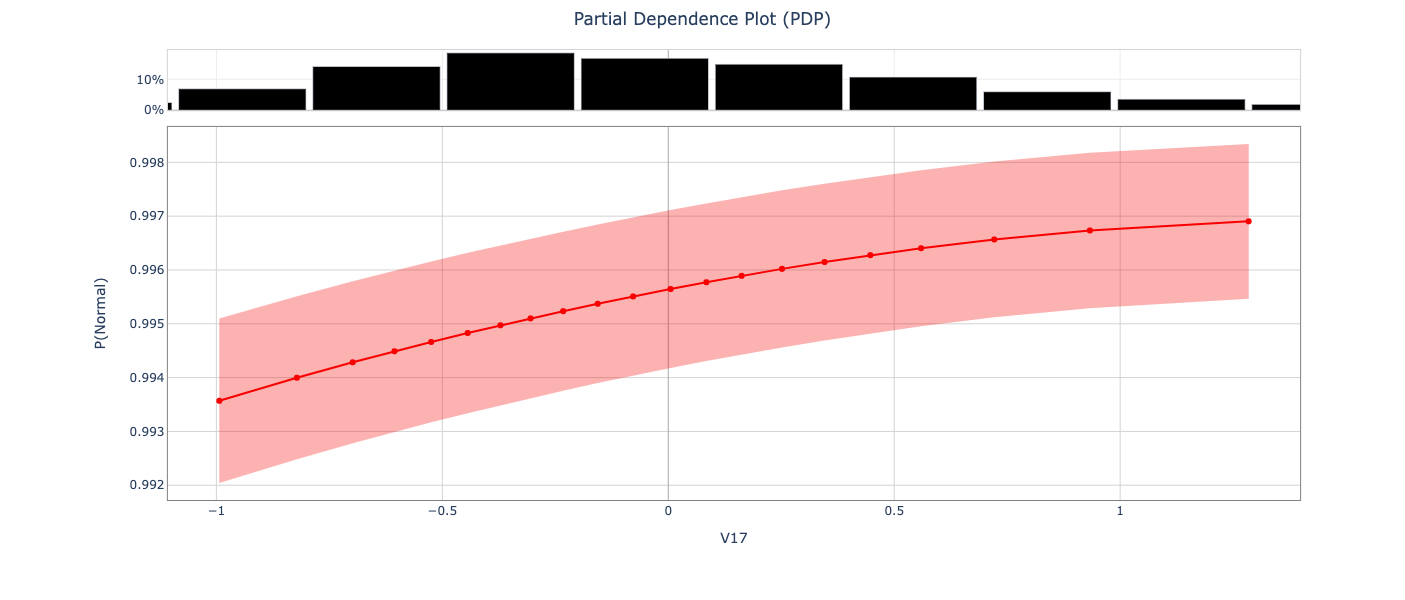

In [26]:
result_explain_feature_dependence_default = explainer.explain_feature_dependence('V17')
result_explain_feature_dependence_default.show_in_notebook()

<a id='MLX-local'></a>
### Prediction Explanations

In addition to the Model's behavior, a user might be curious about decision-logic behind the specific predictions made by the model or the impact of specific feature values on the prediction. The Oracle AutoMLx offers prediction explanations to address such concerns.

<a id='MLX-local'></a>
### Local Feature Importance

Given a data sample, one can also obtain the local importance, which is the importance of the features for the model's prediction on that sample.
In the following cell, we consider sample $1$. The function `explain_prediction()` computes the local importance for a given sample.

In the plot, `V8=0.8878` means that the value of feature `V8` for that sample is `0.8878`. Removing that feature and retraining the model would change the model's prediction by the magnitude of the bar. That is, in this case, the model's prediction for the probability that the point is anomalous is approximately 0.4% larger because the model was able to observe the value for `V8`.

In [27]:
anomaly_indices = np.where(y_pred == 1)[0]

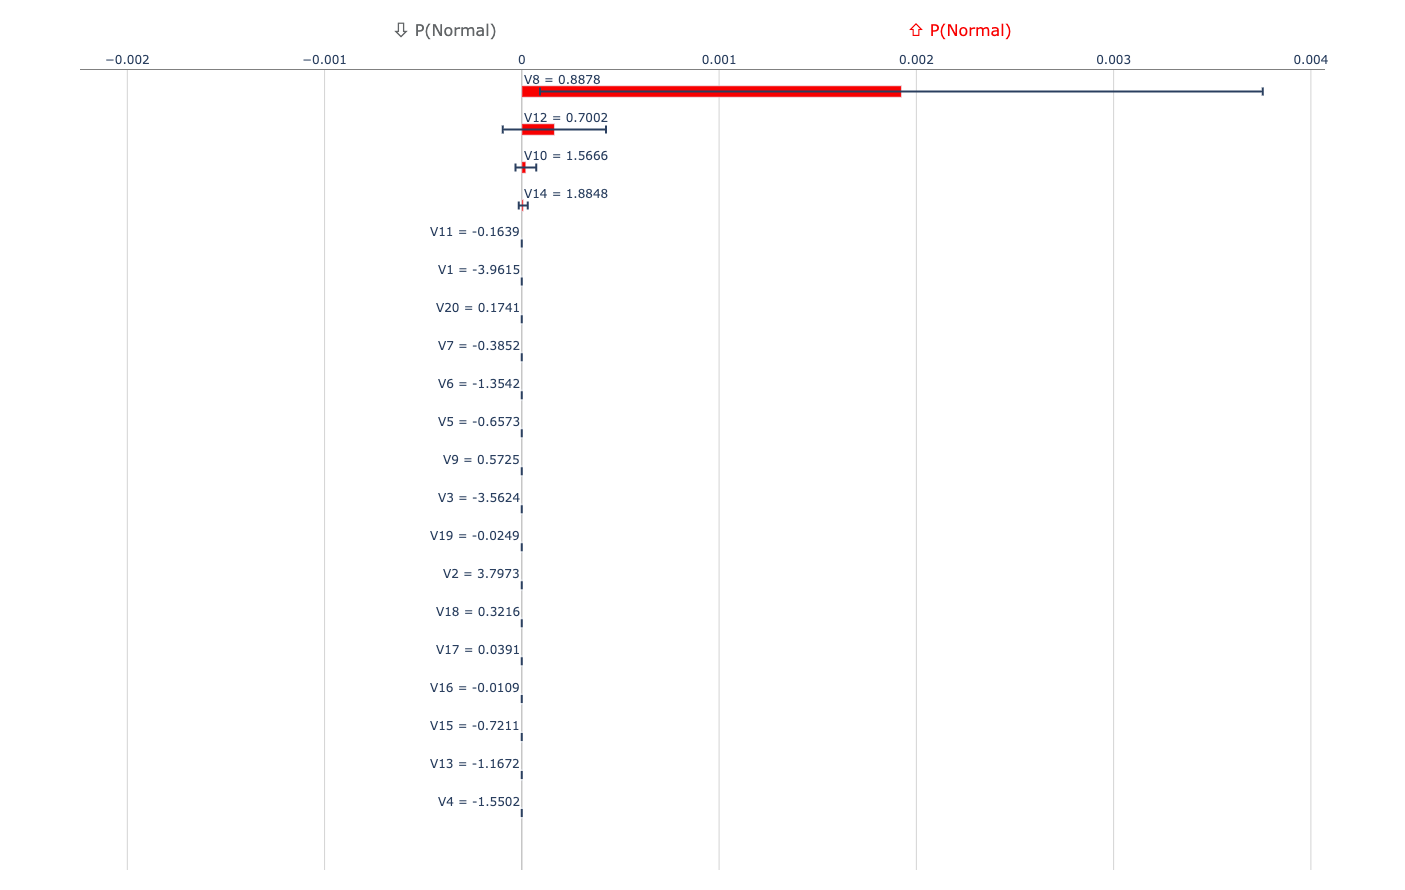

In [28]:
index = anomaly_indices[0]
result_explain_prediction_default = explainer.explain_prediction(X_train.iloc[index:index+1,:])
result_explain_prediction_default[0].show_in_notebook()

<a id='MLX-whatif'></a>
## Interactive What-If Explanations

The Oracle AutoMLx solution offers also What-IF tool to explain a trained ML model's predictions through a simple interactive interface.

You can use What-IF explainer to explore and visualize immediately how changing a sample value will affect the model's prediction. Furthermore, What-IF can be used to visualize how model's predictions are related to any feature of the dataset.

In [ ]:
explainer.explore_whatif(X_test, y_test)

<a id='Counterfactuals'></a>
### Counterfactual Explainers

Counterfactual explainers are another set of advanced features that Oracle AutoMLx supports, which help to explain a trained ML model's predictions by identifying the minimal set of changes necessary to flip the model's decision, resulting in a different outcome. To achieve this, the solution frames the explanation process as an optimization problem, similar to adversarial discoveries, while ensuring that the counterfactual perturbations used are feasible and diverse.

With the Oracle AutoMLx solution, users are guaranteed a close to zero-failure rate in generating a set of counterfactual explanations; the explainers might only fail if the reference training set doesn't contain any example with the desired class.
AutoMLx also provides support for simple constraints on features, using `features_to_fix` and `permitted_range`, to ensure the feasibility of the generated counterfactual examples. Additionally, users can use tunable parameters to control the proximity and diversity of the explanations to the original input.

The Oracle AutoMLx solution supports two strategies for creating counterfactual examples. Users can switch between these strategies by setting `strategy` to one of the following options:

- `ace`: The AutoMLx counterfactual explainer introduced by Oracle Labs that uses KDTree structures to find a set of nearest but diverse counterfactuals per sample.

- `dice_random`: This is a tool for creating diverse counterfactual explanations (https://github.com/interpretml/DiCE).

The final results can be returned either through the interactive interface of `What-IF` tools to show the model's prediction sensitivity or static tables and figures.

In [30]:
explainer.configure_explain_counterfactual(strategy='dice_random')
explanations = explainer.explain_counterfactual(X_test[0:1],
                                                n_counterfactuals=3,
                                                desired_pred='auto')
explanations[0].show_in_notebook()

100%|██████████| 1/1 [00:14<00:00, 14.86s/it]


<a id='MLX-alfi'></a>
### Aggregate Local Feature Importance & Local Feature Importance Built-in Sampling
We now summarize all of the individual local feature importance explanations into one single aggregate explanation.

To speed up the computation of the local feature importance explanations, we enable the explainer's built-in sampling.

In [31]:
explainer.configure_explain_prediction(sampling={'technique': 'random', 'n_samples': 2000})

In [32]:
# We select 5 random instances here as an example and show the aggregate explanation of those instances.
local_explanations = explainer.explain_prediction(X_train.sample(n=5))
alfi = explainer.aggregate(explanations=local_explanations)
alfi.show_in_notebook()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
0,-0.803487,1.517981,2.410004,3.009567,-0.751961,0.528794,-0.337347,0.641477,-1.019373,0.375651,-0.840331,0.691232,1.620946,-0.407612,0.244721,-0.081362,0.308754,0.029732,0.929211,0.258505
1,-0.865171,0.243208,-1.050119,-0.651342,2.710924,-2.018723,0.939969,-0.299333,-0.575338,-0.975941,-0.386162,0.074479,0.537211,-0.688206,0.206936,-0.320797,0.596709,0.052926,-0.219235,0.375068
2,-0.291783,1.601092,-0.205579,2.074332,-0.100355,0.281835,-0.154141,0.341858,-0.125189,0.042513,-0.620210,0.036580,0.606985,-0.995601,1.641579,-0.332127,1.332592,0.760365,1.987634,0.007060
3,1.918817,-0.365623,-0.827857,1.178420,0.215596,0.940729,-0.478664,0.348595,1.135111,0.170075,-0.560728,0.505454,-1.255219,0.096982,-1.634087,0.052469,-0.523154,-0.010676,0.776995,-0.266046
4,0.056348,0.983783,-1.014424,-0.084002,0.211027,-0.995107,0.679188,0.231724,-0.506871,-1.020671,1.237403,0.867945,0.336332,-0.388434,-0.053040,0.312327,0.397300,1.062233,-0.081288,-0.101114


<a id='MLX-advanced'></a>
###  Advanced Feature Importance Configurations
We now display more advanced configuration for computing feature importance. Here, we will explain a custom isolation forest model from the `PyOD` package. Note that the MLExplainer object is capable to explain any anomaly detection model, as long as the model follows a pyod-style interface with the `predict` and `predict_proba` fucntions.

In [33]:
pyod_model = IForest()
pyod_model.fit(X_train, y_train)

y_pred = pd.Series(pyod_model.predict(X_train), index=X_train.index)
explainer_pyod = automl.MLExplainer(pyod_model,
                                    X_train,
                                    target_names=['Normal', 'Anomaly'],
                                    task="anomaly_detection")

<a id='MLX-changing'></a>
#### Changing the number of iterations

One can modify the number of iterations `n_iter` used to evaluate the global importance of the model, or the local importance of a prediction.

Increasing `n_iter` requires a linear increase in computation time. It however provides more
accurate importance estimates, thereby decreasing the variance in repeated calls to
`explain_model`/`explain_prediction`.

The default value is auto, which selects a suitable default value based on the choice of
the method of explanation. Decreasing the number of iterations to 1 also means that the confidence intervals are no longer available.

In this example, because we are explaining a different model, the order of the most important features has changed. 

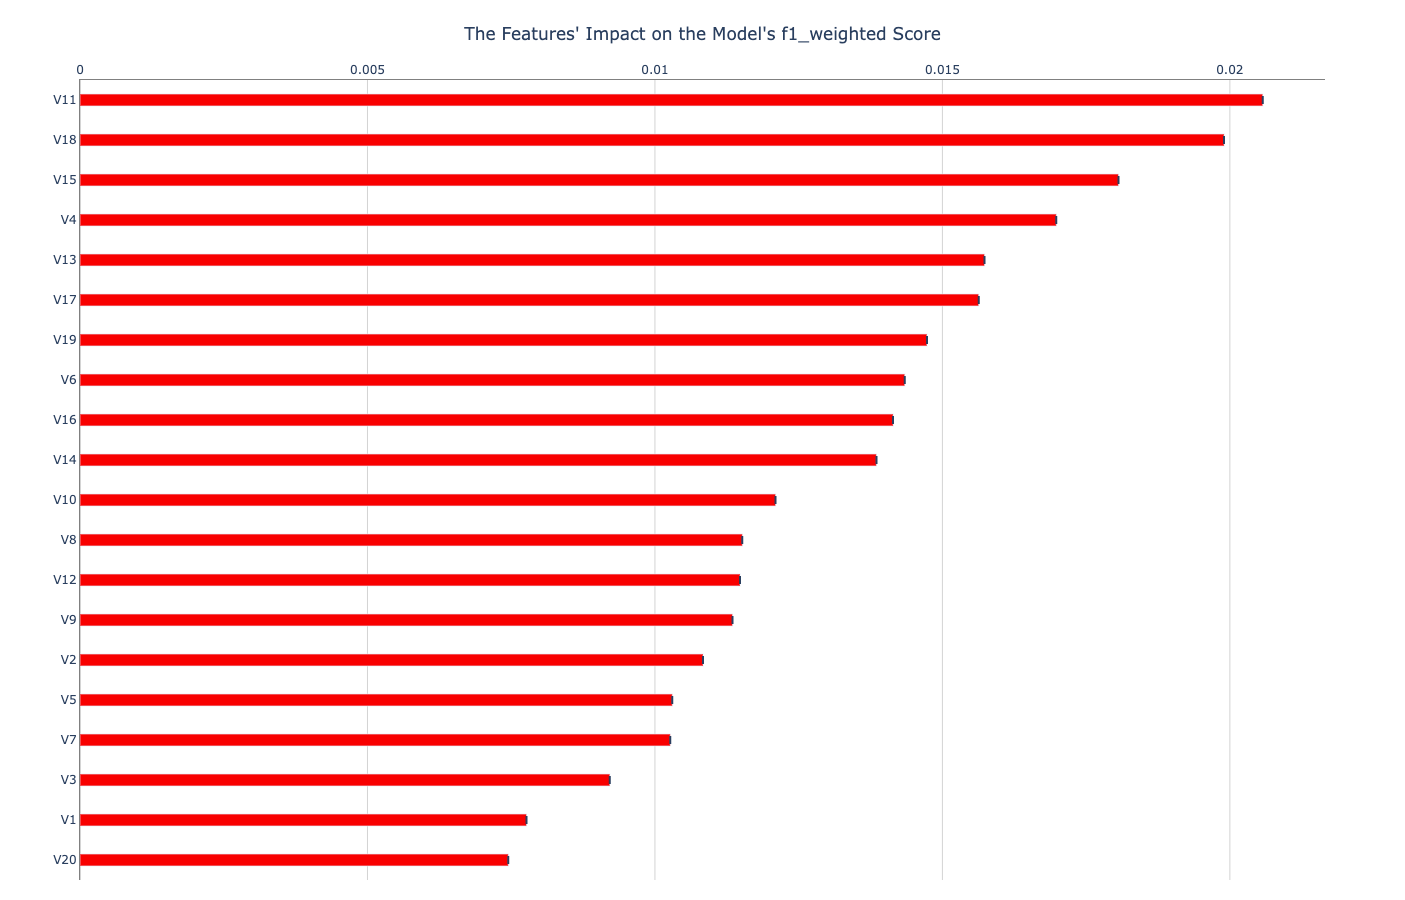

In [34]:
result_explain_model_increase_n_iter = explainer_pyod.explain_model(n_iter=1)
result_explain_model_increase_n_iter.show_in_notebook()

<a id='MLX-including'></a>
#### Including the effects of feature interactions (with Shapley feature importance)

The Oracle AutoMLx solution allows one to change the effect of feature interactions. This can be done through the `tabulator_type` argument of both global and local importance methods. 

`tabulator_type` can be set to one of those three options: `permutation`, `kernel_shap`, `shapley`, `shap_pi`
          
- `permutation`: This value is the default method in the MLExplainer object, and the behaviour was described above

- `kernel_shap`: Feature importance attributions will be calculated using an approximation of the Shapley value method. It typically provides relatively high-quality approximations; however, it currently does not provide confidence intervals.

- `shapley`: Feature importance is computed using the popular game-theoretic Shapley value method. Technically, this measures the importance of each feature while including the effect of all feature interactions. As a result, it runs in exponential time with respect to the number of features in the dataset. This method also includes the interaction effects of the other features, which means that if two features contain duplicate information, they will be less important. Note that the interpretation of this method's result is a bit different from the permutation method's result. An interested reader may find <a href='https://christophm.github.io/interpretable-ml-book/shapley.html'>this</a> a good source for learning more about it.
            
- `shap_pi`: Feature importance attributions will be computed using an approximation of the Shapley value method. It runs in linear time, but may miss the effect of interactions between some features, which may therefore produce lower-quality results. Most likely, you will notice that this method yields larger confidence intervals than the other two.

**Summary: `permutation` can miss important features for AD. Exact SHAP (`shapley`) doesn't, but it is exponential in running time. `kernel_shap` is an approximation of exact SHAP method that does not provide confidence intervals. `shap_pi` is linear, thus faster than exact SHAP and kernel_shap but unstable and very random leads to lower quality approximations.**

<a id='MLX-advance-tabulator-prediction'></a>
##### Local feature importance with kernel_shap

In [35]:
explainer_pyod.configure_explain_prediction(tabulator_type="kernel_shap", 
                                            sampling={'technique': 'random', 'n_samples': 2000})

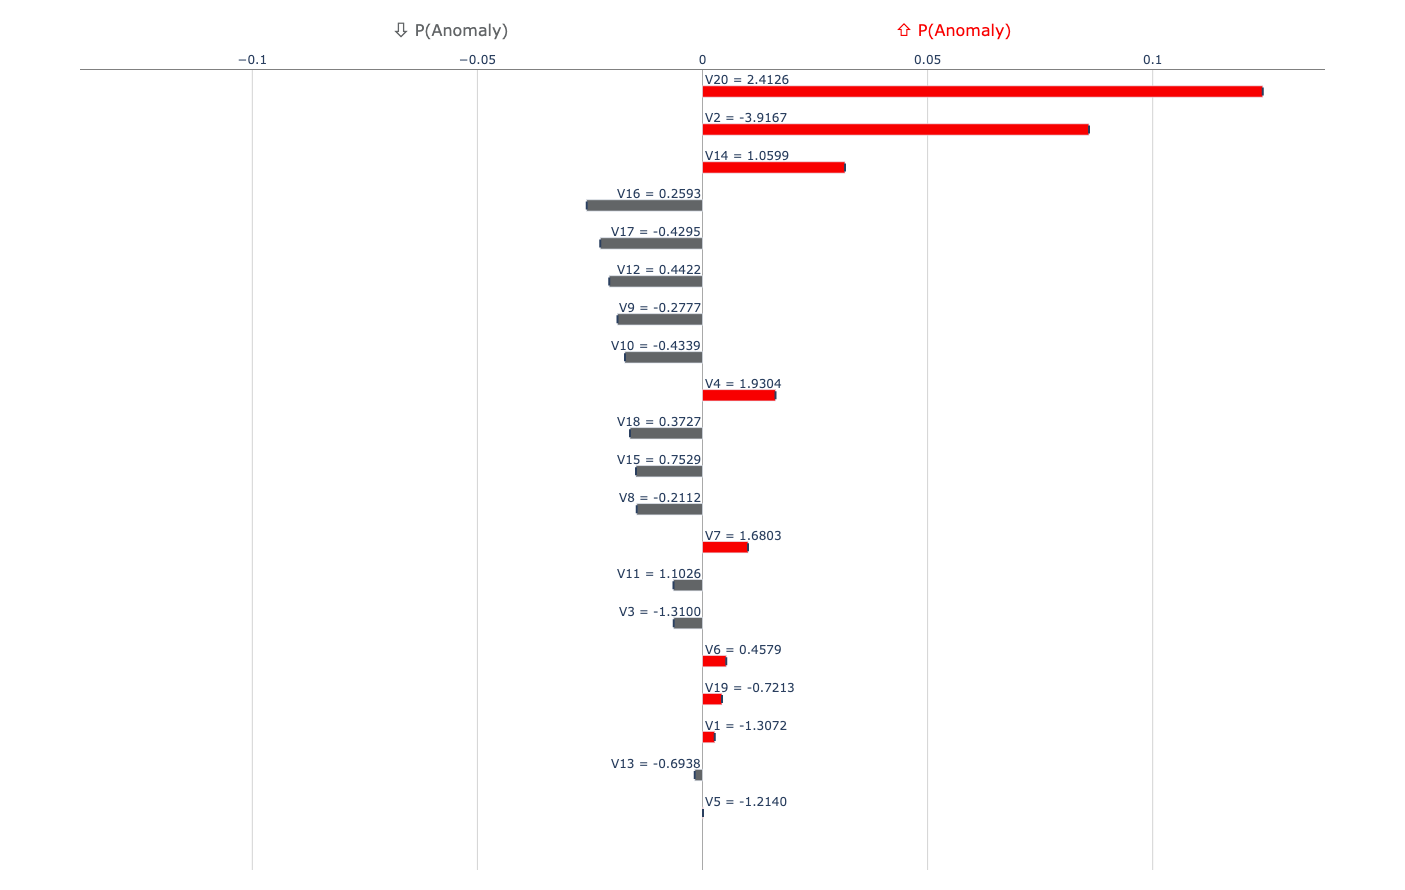

In [36]:
anomaly_indices = np.where(y_pred == 1)[0]
index = anomaly_indices[0]
result_explain_prediction_kernel_shap = explainer_pyod.explain_prediction(X_train.iloc[index:index+1,:])
result_explain_prediction_kernel_shap[0].show_in_notebook()

<a id='MLX-advanced-ale'></a>
### Advanced Feature Dependence Options (ALE)

We now show how to use an alternative method for computing feature dependence: accumulated local effects (ALE). ALE explanations are sometimes considered a better alternative to PDPs when features are correlated, because it does not evaluate the model outside of its training distribution in these cases. For more information, see https://christophm.github.io/interpretable-ml-book/ale.html.

Given a dataset, an ALE displays the average change in the output of the model, accumulated of multiple small changes in one or two features, when all other features are held fixed. By default, the ALE explanations are centered around 0, and thus, unlike PDPs, ALEs show the change in the prediction measured by changing a given feature, rather than the average model's prediction for a particular feature value.

The X-axis is the value of the `V17` feature and the y-axis is the corresponding computed ALE (price unit).

The histogram on top shows the distribution of the value of the `V17` feature in the dataset.

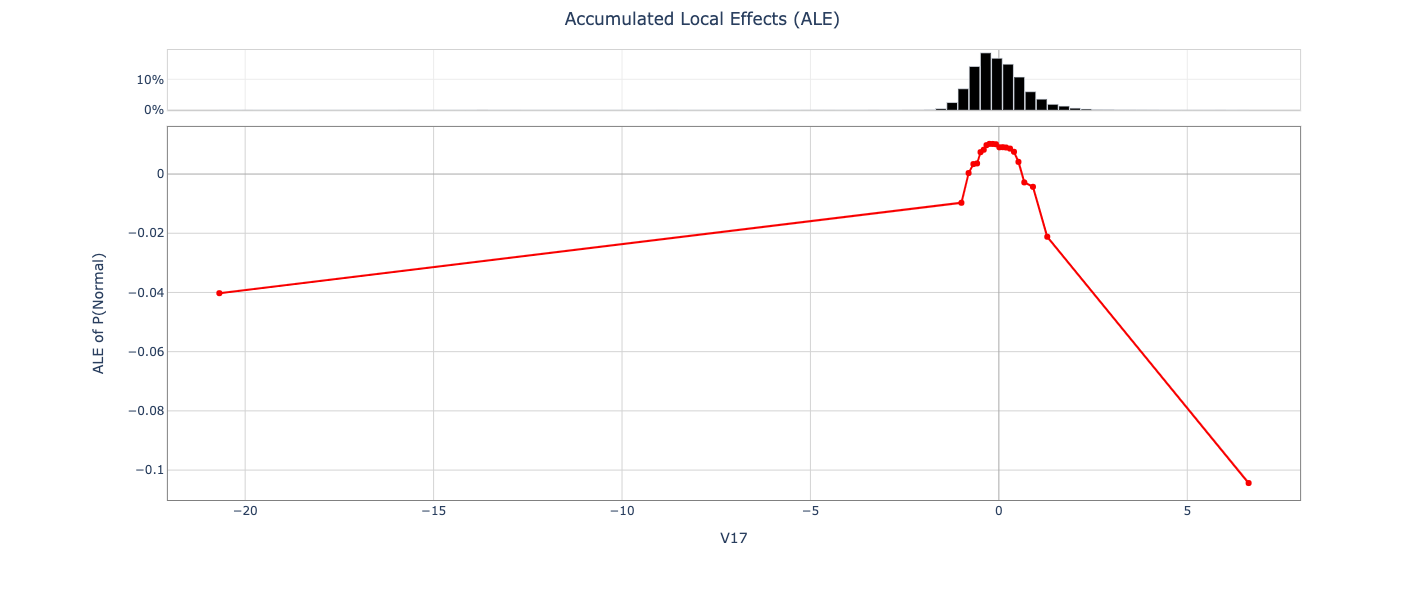

In [37]:
explainer_pyod.configure_explain_feature_dependence(explanation_type='ale')
result_explain_feature_dependence_default = explainer_pyod.explain_feature_dependence(['V17'])
result_explain_feature_dependence_default.show_in_notebook()

<a id='ref'></a>
## References
* More examples and details: http://automl.oraclecorp.com/
* Oracle AutoML http://www.vldb.org/pvldb/vol13/p3166-yakovlev.pdf
* scikit-learn https://scikit-learn.org/stable/
* Interpretable Machine Learning https://christophm.github.io/interpretable-ml-book/
* LIME https://arxiv.org/pdf/1602.04938
* OpenML (Credit Card Fraud Dataset) https://www.openml.org/d/1597
